In [1]:
%matplotlib widget

import numpy as np

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_priors import sig0_dc, calc_priors, plot_posteriors

# Priors

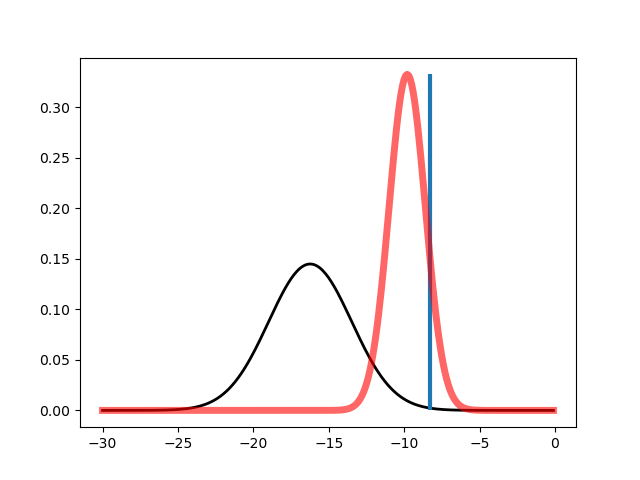

In [2]:
water_prior, land_prior = calc_priors(0, plot=True)

# Posteriors

In [3]:
def calc_posteriors(water_prior, land_prior):
    evidence = (water_prior * 0.5) + (land_prior * 0.5)
    return (water_prior * 0.5) / evidence,  (land_prior * 0.5) / evidence

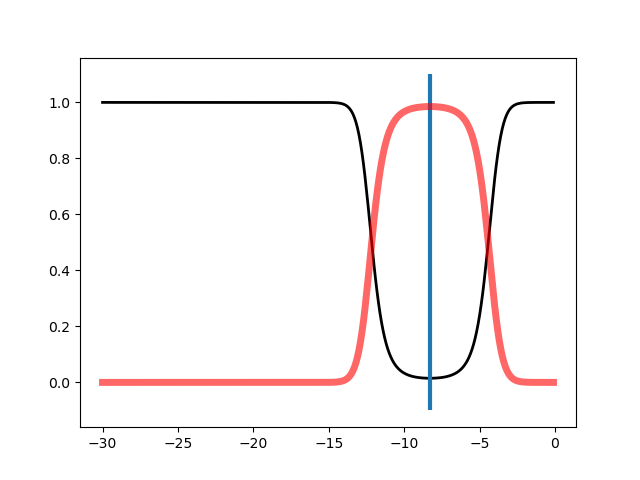

In [4]:
f_post_prob, nf_post_prob = calc_posteriors(water_prior, land_prior)
plot_posteriors(0, f_post_prob, nf_post_prob)

# Flood Classification

In [5]:
def bayesian_flood_decision(id, sig0_dc):
    f_post_prob, nf_post_prob = calc_posteriors(*calc_priors(id,  sig0_dc))
    return np.greater(nf_post_prob, f_post_prob)

bayesian_flood_decision(0, sig0_dc.SIG0.where(sig0_dc.id==0, drop=True))

array([ True])

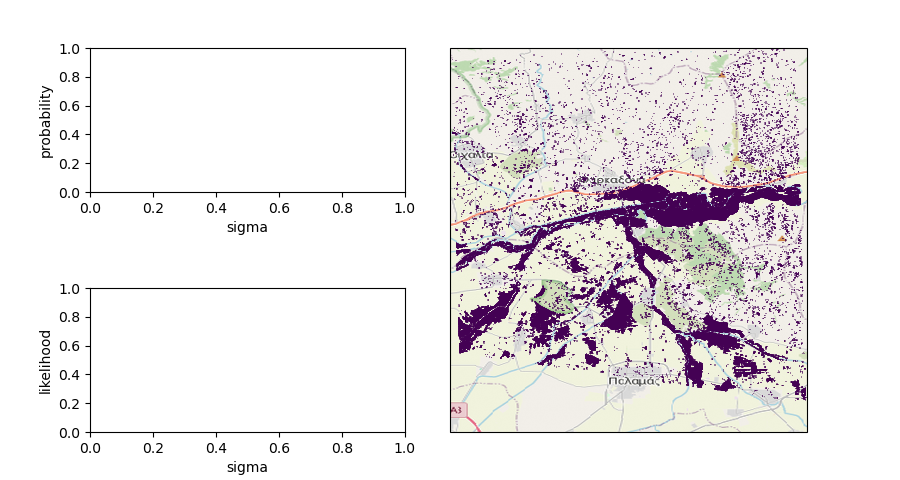

In [6]:
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)